In [ ]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Chargement et préparation des données

# Importation des données avec pandas
data = pd.read_csv('drive/MyDrive/credit_scoring.csv', sep=';')

# Affichage des premières lignes du dataset pour vérifier son contenu
print(data.head())

nom_cols = data.columns.values[:-1] # first items without Status

# Conversion en numpy array
X = data.drop(columns=["Status"]).values # Sélection des colonnes de caractéristique
y = data["Status"].values # Sélection de la variable cible

# Analyser les propriétés des données
print("Taille de l'échantillon :", data.shape) # Taille de l'échantillon

# Pourcentage d'exemples positifs et négatifs
positive_count = np.sum(y == 1)
negative_count = np.sum(y == 0)
total_count = len(y)
print("Pourcentage d'exemples positifs :", (positive_count / total_count) * 100, "%")
print("Pourcentage d'exemples négatifs :", (negative_count / total_count) * 100, "%")

# Séparation des données en jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Vérification des tailles
print("Taille du jeu d'apprentissage :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)

   Seniority  Home  Time   Age  Marital  Records  Job  Expenses  Income  \
0        9.0   1.0  60.0  30.0      0.0      1.0  1.0      73.0   129.0   
1       17.0   1.0  60.0  58.0      1.0      1.0  0.0      48.0   131.0   
2       10.0   0.0  36.0  46.0      0.0      2.0  1.0      90.0   200.0   
3        0.0   1.0  60.0  24.0      1.0      1.0  0.0      63.0   182.0   
4        0.0   1.0  36.0  26.0      1.0      1.0  0.0      46.0   107.0   

   Assets  Debt  Amount   Price  Status  
0     0.0   0.0   800.0   846.0       1  
1     0.0   0.0  1000.0  1658.0       1  
2  3000.0   0.0  2000.0  2985.0       0  
3  2500.0   0.0   900.0  1325.0       1  
4     0.0   0.0   310.0   910.0       1  
Taille de l'échantillon : (4375, 14)
Pourcentage d'exemples positifs : 72.20571428571428 %
Pourcentage d'exemples négatifs : 27.794285714285717 %
Taille du jeu d'apprentissage : (2187, 13)
Taille du jeu de test : (2188, 13)


In [ ]:
# 2. Les modèles à comparer
models = {
    "CART": DecisionTreeClassifier(random_state=1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
}

# Entrainnement du modèle
for model_name, model in models.items():
    model.fit(X_train, y_train)



In [ ]:
def evaluate_models(models, X_test, y_test):

    results = {}

    for model_name, model in models.items():
        # Prédictions
        y_pred = model.predict(X_test)

        results[model_name] = {
            "cm": confusion_matrix(y_test, y_pred),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        }

    return results

def show_results(results):
    for model_name, metrics in results.items():
        print(f"Résultats pour le modèle {model_name}:")
        print(f"Matrice de confusion:\n{metrics['cm']}")
        print(f"Accuracy : {metrics['accuracy']:.2f}")
        print(f"Précision : {metrics['precision']:.2f}")
        print(f"Rappel : {metrics['recall']:.2f}")
        print(f"------")

# Appel de la fonction pour évaluer et comparer les modèles
results = evaluate_models(models, X_test, y_test)

show_results(results)

Résultats pour le modèle CART:
Matrice de confusion:
[[ 325  279]
 [ 318 1266]]
Accuracy : 0.73
Précision : 0.82
Rappel : 0.80
------
Résultats pour le modèle KNN:
Matrice de confusion:
[[ 189  415]
 [ 187 1397]]
Accuracy : 0.72
Précision : 0.77
Rappel : 0.88
------
Résultats pour le modèle MLP:
Matrice de confusion:
[[ 285  319]
 [ 342 1242]]
Accuracy : 0.70
Précision : 0.80
Rappel : 0.78
------


Dans le cas métier du crédit scoring, la mesure la plus importante entre le rappel et la précision est bien la précision, afin d'éviter les faux positifs.

Si l'on considère une matrice de confusion dans le cas métier du crédit scoring, elle pourrait se présenter comme suit :
```

                    | Solvable (Positif)  | Non solvable (Négatif)
--------------------|---------------------|-------------------------
Prédit Solvable     | Vrais Positifs (VP) | Faux Positifs (FP)
Prédit Non Solvable | Faux Négatifs (FN)  | Vrais Négatifs (VN)
```

* VP : Bon emprunteur identifié comme bon (vrai positif).
* FP : Mauvais emprunteur identifié comme bon (faux positif).
* FN : Bon emprunteur identifié comme mauvais (faux négatif).
* VN : Mauvais emprunteur identifié comme mauvais (vrai négatif).

Dans cette optique, nous souhaitons :

* Minimiser FP (mauvais emprunteur identifié comme bon).
* Maximiser VP (bon emprunteur identifié correctement).

et éventuellement;

* Minimiser FN (bon emprunteur identifié comme mauvais).

Dans notre TP nous nous concentrerons exclusivement sur la **précision**. Une entreprise pourrait utiliser une moyenne harmonique avec un poids plus faible sur le FN selon son business plan.


In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_on_scaled = {
    "CART_on_scaled": DecisionTreeClassifier(random_state=1),
    "KNN_on_scaled": KNeighborsClassifier(n_neighbors=5),
    "MLP_on_scaled": MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
}

# Entrainnement du modèle
for model_name, model in models_on_scaled.items():
    model.fit(X_train_scaled, y_train)

# Comparaison des modèles
results_on_normalized = evaluate_models(models_on_scaled, X_test_scaled, y_test)

show_results(results_on_normalized)

def best_model_by_precision(data):
    # Vérifie que le dictionnaire n'est pas vide
    if not data:
        return None

    # Utilise max() pour trouver l'élément avec la meilleure précision
    best_key, best_value = max(data.items(), key=lambda item: item[1].get("precision", 0))
    best_value["name"] = best_key;
    # Retourne l'élément avec la meilleure précision
    return best_value

best_model = best_model_by_precision(results | results_on_normalized)



Résultats pour le modèle CART_on_scaled:
Matrice de confusion:
[[ 325  279]
 [ 315 1269]]
Accuracy : 0.73
Précision : 0.82
Rappel : 0.80
------
Résultats pour le modèle KNN_on_scaled:
Matrice de confusion:
[[ 283  321]
 [ 236 1348]]
Accuracy : 0.75
Précision : 0.81
Rappel : 0.85
------
Résultats pour le modèle MLP_on_scaled:
Matrice de confusion:
[[ 314  290]
 [ 173 1411]]
Accuracy : 0.79
Précision : 0.83
Rappel : 0.89
------


In [ ]:
print(f"Le meilleur modèle par rapport à la précision est : {best_model['name']}")

Le meilleur modèle par rapport à la précision est : MLP_on_scaled


In [ ]:
if best_model['name'].endswith("on_scaled"):
  X_train = X_train_scaled
  X_test = X_test_scaled


Le **meilleurs modèle** à ce stade pour ces données et ce cas métier est donc **MLP sur des données normalisées** pour avoir la meilleurs précision.

['Seniority' 'Home' 'Time' 'Age' 'Marital' 'Records' 'Job' 'Expenses'
 'Income' 'Assets' 'Debt' 'Amount' 'Price']
['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


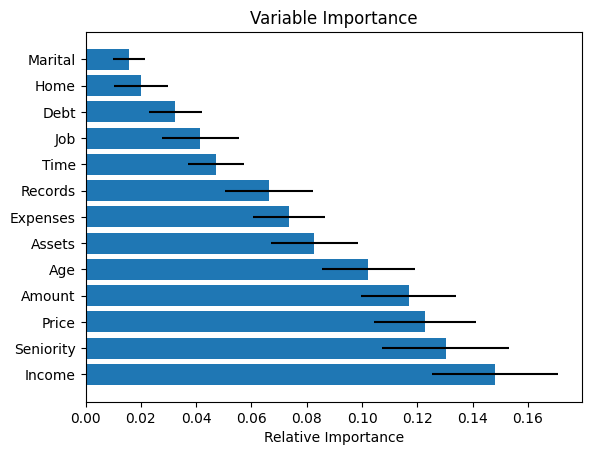

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000,random_state=1)
clf.fit(X_train, y_train)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = nom_cols

print(nom_cols)

print(features[sorted_idx])


padding = np.arange(X_train.size/len(X_train)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

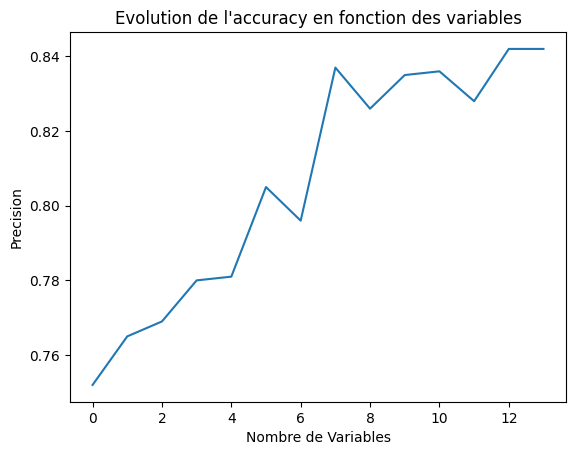

In [ ]:


best_model_instance = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
  X1_f = X_train[:,sorted_idx[:f+1]]
  X2_f = X_test [:,sorted_idx[:f+1]]
  best_model_instance.fit(X1_f,y_train)
  y_pred=best_model_instance.predict(X2_f)
  scores[f]=np.round(precision_score(y_test,y_pred),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Precision")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

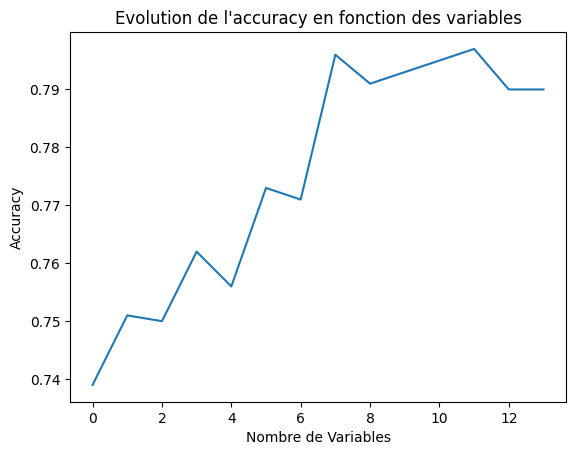

In [ ]:

best_model_instance = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
  X1_f = X_train[:,sorted_idx[:f+1]]
  X2_f = X_test [:,sorted_idx[:f+1]]
  best_model_instance.fit(X1_f,y_train)
  y_pred=best_model_instance.predict(X2_f)
  scores[f]=np.round(accuracy_score(y_test,y_pred),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()